# Settings

In [5]:
import pyspark
sc = pyspark.SparkContext(appName="Clustering Task")


In [6]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import col

# Data Preparation

In [8]:
sqlContext = SQLContext(sc)
#indexer needed so that labels are 0 and 1

schema = StructType([ StructField("c"+str(0),StringType())]+[ StructField("c"+str(i),DoubleType()) for i in range(1,8)])
# schema to cast data, can use inferschema also

raw_data = sqlContext.read.csv("/content/drive/MyDrive/exo2_tocluster.csv",schema=schema)
#droping rows with nulls
raw_data_nn = raw_data.dropna()

assembled_data = VectorAssembler(inputCols=["c"+str(i) for i in range(1,8)],outputCol="features").transform(raw_data)

#standardizing the data
scale=StandardScaler(inputCol='features',outputCol='standardized_features')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [9]:
data_scale_output.show()

+---------------+-----------+------------+------------+------------+-------------+------------+------------+--------------------+---------------------+
|             c0|         c1|          c2|          c3|          c4|           c5|          c6|          c7|            features|standardized_features|
+---------------+-----------+------------+------------+------------+-------------+------------+------------+--------------------+---------------------+
| exo2-cluster-1|31002.31324|-80967.66086|  77883.5258| 48843.18235| -99379.82955| -5869.91744| 12089.14713|[31002.31324,-809...| [1.97667049621761...|
| exo2-cluster-2|30896.98816|-54473.15729| 73882.56923| 76768.40358|-106211.69278|  13313.0134| 16658.48435|[30896.98816,-544...| [1.96995509480430...|
| exo2-cluster-3|17374.16934|-59403.69201| 27580.31884| 79138.68698| -19277.60536|  3190.04834| 68552.28418|[17374.16934,-594...| [1.10775630401528...|
| exo2-cluster-4| 30012.5232|-61078.92925| 67626.07322| 82263.71013| -90379.28654| -2586

# Cluster Selection

## K-Means

In [10]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

### Unstandardized data

In [11]:
silhouette_score=[]
evaluator_silhouette = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')

cost = []
X = range(2,27)

# we train the Kmeans models 10 times in order to soften the curves and avoid rare cases since kmeans is initialized with random centroids
for _ in range(10):
  S, I = [], []
  
  for i in X: # ie with cluster numbers ranging from 2 to 26
      print('For', i, 'clusters :')
      #training the model
      KMeans_algo=KMeans(featuresCol='features', k=i)
      KMeans_fit=KMeans_algo.fit(data_scale_output)
      
      #predictions of clusters on data
      output=KMeans_fit.transform(data_scale_output)
      
      #evaluating the models
      score=evaluator_silhouette.evaluate(output)
      S.append(score)
      print("Silhouette Score:",score)
      
      I.append(KMeans_fit.summary.trainingCost)
      print("Costcore:",KMeans_fit.summary.trainingCost)
      print('\n')
    
  silhouette_score.append(S)
  cost.append(I)

For 2 clusters :
Silhouette Score: 0.5281961786048502
Costcore: 97398358153224.78


For 3 clusters :
Silhouette Score: 0.5863509424206879
Costcore: 53945906761634.84


For 4 clusters :
Silhouette Score: 0.8513313751452095
Costcore: 16460898387063.266


For 5 clusters :
Silhouette Score: 0.8640178155575339
Costcore: 9353370540106.291


For 6 clusters :
Silhouette Score: 0.7288752771207726
Costcore: 15736417009325.643


For 7 clusters :
Silhouette Score: 0.6487627383747253
Costcore: 8396508602172.729


For 8 clusters :
Silhouette Score: 0.566310057669468
Costcore: 7930806516350.441


For 9 clusters :
Silhouette Score: 0.44758517013342636
Costcore: 7420600158210.563


For 10 clusters :
Silhouette Score: 0.47941822448868526
Costcore: 7202147628388.04


For 11 clusters :
Silhouette Score: 0.5388032218898711
Costcore: 7312008522546.14


For 12 clusters :
Silhouette Score: 0.46262904231778296
Costcore: 6750916383373.282


For 13 clusters :
Silhouette Score: 0.3507352584014879
Costcore: 637587

In [14]:
mean_Sil, mean_Cost = np.mean(silhouette_score, axis=0), np.mean(cost, axis=0)

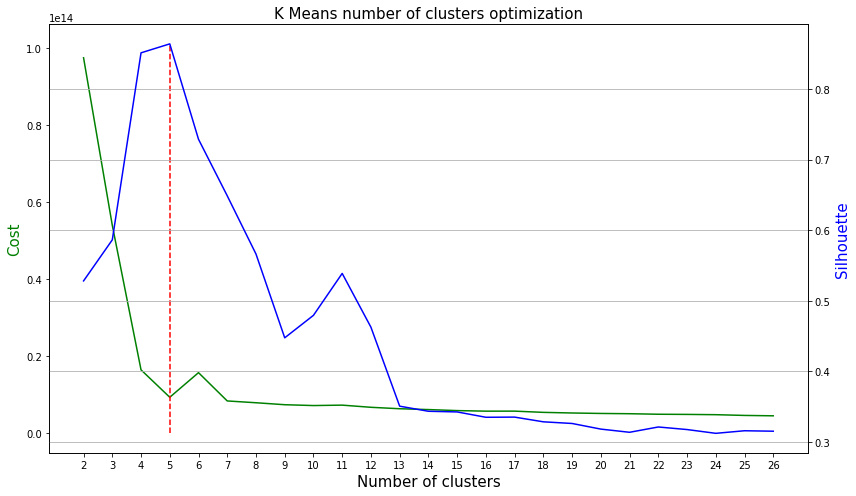

In [25]:
fig, ax1 = plt.subplots(figsize=(12,7))

ax1.set_xlabel('Number of clusters', fontsize=15)
ax1.set_ylabel('Cost', fontsize=15, color='green')
ax1.plot(X, mean_Cost, color='green')
ax1.plot([5,5],[0,1e14+1e12], linestyle='dashed', color='red')
ax1.set_xticks(X)

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette', fontsize=15, color='blue')
ax2.plot(X, mean_Sil, color='blue')


plt.grid()
plt.title('K Means number of clusters optimization', fontsize=15)
fig.tight_layout()  
plt.show()

After analyzing the previous graph where we've calculated the sum of squares and the silhouette score, we can deduce the optimal number of clusters.

Indeed, by applying the elbow to the cost curve we can deduce that the optimal number of clusters is between 5 and 7.

Also, by looking at the silhouette curve we can deduce that the optimal number of clusters is the one for which we get maximum silhouette score therefor the number of clusters 4 and 5 would be good candidates.

From the candidates obtained from the cost and silhouette scores we can confidently say that the optimal number of clusters is 5.

In [46]:
optimal_K = 5
KMeans_algo=KMeans(featuresCol='features', k=optimal_K)
KMeans_fit=KMeans_algo.fit(data_scale_output)
output=KMeans_fit.transform(data_scale_output)

### Standardized data

In [39]:
silhouette_score=[]
evaluator_silhouette = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized_features', metricName='silhouette', distanceMeasure='squaredEuclidean')

cost = []
X = range(2,27)

for _ in range(10):
  S, I = [], []
  
  for i in X:
      print('For', i, 'clusters :')
      #training the model
      KMeans_algo=KMeans(featuresCol='standardized_features', k=i)
      KMeans_fit=KMeans_algo.fit(data_scale_output)
      
      #predictions of clusters on data
      output=KMeans_fit.transform(data_scale_output)
      
      #evaluating the models
      score=evaluator_silhouette.evaluate(output)
      S.append(score)
      print("Silhouette Score:",score)
      
      I.append(KMeans_fit.summary.trainingCost)
      print("Costcore:",KMeans_fit.summary.trainingCost)
      print('\n')
    
  silhouette_score.append(S)
  cost.append(I)

For 2 clusters :
Silhouette Score: 0.6359534200606789
Costcore: 37709.50563511925


For 3 clusters :
Silhouette Score: 0.5745698175404558
Costcore: 27584.49456199632


For 4 clusters :
Silhouette Score: 0.6523429230695866
Costcore: 16826.51918044043


For 5 clusters :
Silhouette Score: 0.6785003441178731
Costcore: 12638.200060354855


For 6 clusters :
Silhouette Score: 0.6370744602986391
Costcore: 11751.77838349947


For 7 clusters :
Silhouette Score: 0.5683580049926891
Costcore: 10833.186777899558


For 8 clusters :
Silhouette Score: 0.5326534289082079
Costcore: 9983.591450117774


For 9 clusters :
Silhouette Score: 0.4832621138404441
Costcore: 9014.687330662406


For 10 clusters :
Silhouette Score: 0.5262669767395997
Costcore: 9294.856093012158


For 11 clusters :
Silhouette Score: 0.45614144141181595
Costcore: 7780.455160518624


For 12 clusters :
Silhouette Score: 0.45258943117668476
Costcore: 7388.500213667082


For 13 clusters :
Silhouette Score: 0.4395356590793189
Costcore: 7109

In [40]:
mean_Sil, mean_Cost = np.mean(silhouette_score, axis=0), np.mean(cost, axis=0)

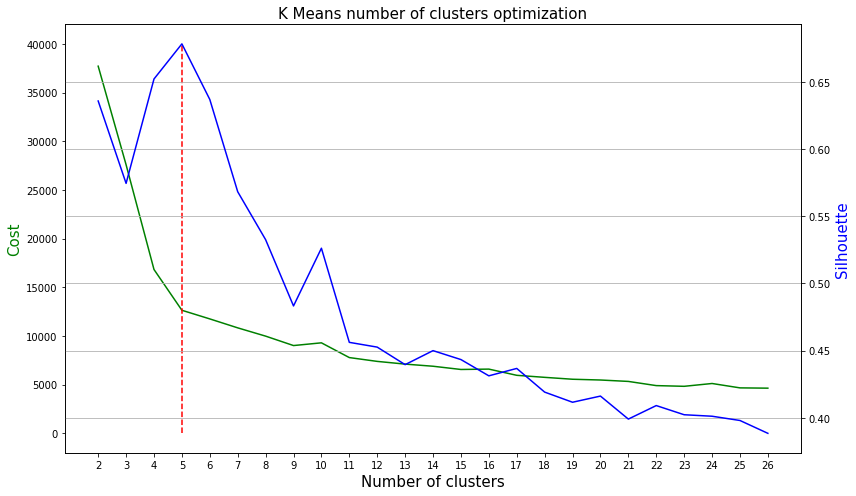

In [45]:
fig, ax1 = plt.subplots(figsize=(12,7))

ax1.set_xlabel('Number of clusters', fontsize=15)
ax1.set_ylabel('Cost', fontsize=15, color='green')
ax1.plot(X, mean_Cost, color='green')
ax1.plot([5,5],[0,40000], linestyle='dashed', color='red')
ax1.set_xticks(X)

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette', fontsize=15, color='blue')
ax2.plot(X, mean_Sil, color='blue')


plt.grid()
plt.title('K Means number of clusters optimization', fontsize=15)
fig.tight_layout()  
plt.show()

By standadizing the data, we can detect that 5 is a candidate with more confidence than before. However, we are less confident with elbow method since the curve descent is much smoother than before therefor increasing the number of candidates and descresing our confidence.

In [63]:
optimal_K = 5
KMeans_algo=KMeans(featuresCol='features', k=optimal_K)
KMeans_fit=KMeans_algo.fit(data_scale_output)
output_non_stand=KMeans_fit.transform(data_scale_output)

In [64]:
KMeans_algo=KMeans(featuresCol='standardized_features', k=optimal_K)
KMeans_fit=KMeans_algo.fit(data_scale_output)

#predictions of clusters on data
output_stand=KMeans_fit.transform(data_scale_output)

## Comparing the predictions made by each of the models

In [65]:
pred_non_stand = [w.prediction for w in output_non_stand.select('prediction').collect()]
pred_stand = [w.prediction for w in output_stand.select('prediction').collect()]

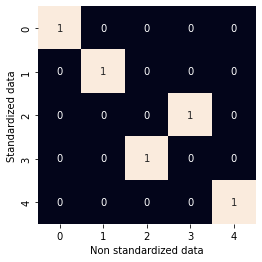

In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import seaborn as sn

cm = confusion_matrix(pred_non_stand, pred_stand, labels=range(5))

normed_cm = normalize(cm, axis=1, norm='l1')

sn.heatmap(normed_cm.T, square=True, annot=True, cbar=False,
            xticklabels=range(5),
            yticklabels=range(5))
plt.xlabel('Non standardized data')
plt.ylabel('Standardized data')
plt.show()

We get perfect similarity to the predictions made by the kmeans on standardized data and not standardized one.

# Testing

In [83]:
pred = [w.prediction for w in output_stand.select('prediction').collect()]
ind = [w.c0 for w in output_stand.select('c0').collect()]

In [101]:
dic = dict()
for i in range(optimal_K):
  dic[i] = chr(ord('a') + i)

In [104]:
with open('exo2.csv','wb') as file:
  for p, i in zip(pred, ind):
    file.write((str(i)+','+str(dic[p])+'\n').encode())

  file.write((opti_letter).encode())